# Applied Machine Learning - Coursework 1

Alex Scholtes (C21117159)

#### Contents:

- Read data
- Data Exploration
- Data pre-processing
- Modelling:
>- k-nearest neighbours
>- Logistic regression
>- Decision tree
- Model Evaluation

## Read Data

Read data as pandas data frame:

In [ ]:
import pandas as pd

df_path = "/content/drive/MyDrive/Colab Notebooks/CMT307 - Applied Machine Learning/Coursework/Data.csv"

df_raw = pd.read_csv(df_path)

In [ ]:
df_raw.shape

(304887, 12)

Split data into training and test data:

In [ ]:
from sklearn.model_selection import train_test_split

X = df_raw.drop("Result", axis = 1)
y = df_raw.Result

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

## Data Exploration

To get an idea of what the data and the features look like, I look at the head and tail of the data, including the target variable `Result`:

In [ ]:
eda = pd.concat([X_train, y_train], axis = 1)
eda

,id,Gender,Age,HasDrivingLicense,RegionID,Switch,VehicleAge,PastAccident,AnnualPremium,SalesChannelID,DaysSinceCreated,Result
197336,81971,Male,24.0,1.0,8.0,NaN,< 1 Year,No,"£1,739.30",152,75,0
219909,367712,Male,25.0,1.0,8.0,0.0,< 1 Year,NaN,"£1,479.50",152,112,0
293179,318937,Male,20.0,1.0,37.0,0.0,< 1 Year,NaN,"£1,905.70",160,288,0
121853,168094,Male,55.0,1.0,28.0,NaN,1-2 Year,No,"£2,202.05",124,60,0
58523,261595,Female,39.0,1.0,49.0,1.0,1-2 Year,NaN,"£1,459.75",124,245,0
...,...,...,...,...,...,...,...,...,...,...,...,...
201552,370259,Female,47.0,1.0,28.0,1.0,1-2 Year,NaN,"£3,331.00",52,81,0
123728,221832,Male,75.0,1.0,6.0,1.0,1-2 Year,No,"£2,162.85",26,11,0
215125,371210,Male,21.0,NaN,17.0,NaN,< 1 Year,NaN,"£2,038.90",160,141,0
114359,246665,Male,49.0,1.0,41.0,1.0,1-2 Year,No,"£2,043.15",124,90,0


In [ ]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213420 entries, 197336 to 143142
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 213420 non-null  int64  
 1   Gender             192153 non-null  object 
 2   Age                192068 non-null  float64
 3   HasDrivingLicense  192094 non-null  float64
 4   RegionID           192132 non-null  float64
 5   Switch             106880 non-null  float64
 6   VehicleAge         192247 non-null  object 
 7   PastAccident       106598 non-null  object 
 8   AnnualPremium      213420 non-null  object 
 9   SalesChannelID     213420 non-null  int64  
 10  DaysSinceCreated   213420 non-null  int64  
 11  Result             213420 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 21.2+ MB


We have a mix of binary, categorical, discrete, and continuous features, and already see some missing values (which will be dealt with later).

I first count the occurences of levels in the cateogircal features:

In [ ]:
cat_features = ["Gender", "HasDrivingLicense", "RegionID", "Switch", "VehicleAge", "PastAccident", "SalesChannelID"]

for col in eda.loc[:,cat_features]:
  print(eda[col].value_counts(dropna = False), "\n")

Male      103975
Female     88178
NaN        21267
Name: Gender, dtype: int64 

1.0    191686
NaN     21326
0.0       408
Name: HasDrivingLicense, dtype: int64 

28.0    53832
NaN     21288
8.0     16827
46.0     9983
41.0     9136
15.0     6790
30.0     6181
29.0     5552
50.0     5149
3.0      4683
11.0     4588
36.0     4411
33.0     3844
47.0     3692
35.0     3591
6.0      3188
45.0     2796
37.0     2778
18.0     2658
48.0     2401
39.0     2365
14.0     2358
10.0     2191
21.0     2187
13.0     2058
2.0      2024
7.0      1693
12.0     1608
9.0      1541
27.0     1454
32.0     1417
17.0     1315
43.0     1314
26.0     1313
25.0     1290
24.0     1266
0.0      1023
16.0      989
23.0      985
20.0      974
38.0      965
31.0      962
49.0      934
4.0       906
34.0      827
19.0      798
22.0      653
40.0      647
5.0       597
1.0       504
44.0      401
42.0      285
52.0      125
51.0       83
Name: RegionID, dtype: int64 

NaN    106540
0.0     57770
1.0     49110
Name: Swi

In [ ]:
len(X_train.RegionID.value_counts())

53

`RegionID` and `SalesChannelID` have many different levels, with `SalesChannelID` having a few that only occur once. Otherwise, only `VehicleAge` is non-binary and only has three levels.

`Gender`: There are about 15,000 more males than females in the dataset and just over 20,000 missing values.

`HasDrivingLicense`: There are only about 400 customers in the dataset who do not have a driving license, and about 20,000 who have a missing value here. This would intuitively be crucial information since it would make sense that a customer without a driving license will be far less likely to purchase car insurance than one with a driving license.

`RegionId`: Region 28 has the most occurences in the dataset, with the next most common value having less than half as many occurences and being a missing value. There are around 10-15 features with less than 1,000 occurences and one region (51) with less than 100.

`Switch`: Roughly even split between 1 and 0, with slightly more 0. Majority are missing values (around half of all observations).

`VehicleAge`: Most vehciles are 1-2 years old with a close second being less than 1 year. There are again around 20,000 missing values and just under 10,000 customers whose vehicle is more than 2 years old.

`PastAccident`: Equal split between yes and no but around half of all observations are missing.

`SalesChannelID`: 152, 26, and 124 make up the majority of the observations for this feature, but there are 147 different levels for this feature.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

def draw_boxplot_hist(feature, n_bins):

  x = eda[feature].dropna()

  x0 = eda.loc[eda.Result == 0, feature].dropna()
  x1 = eda.loc[eda.Result == 1, feature].dropna()

  bins = np.append(np.arange(min(x), max(x), (max(x) - min(x)) / (n_bins + 1)), max(x)).astype(int)

  print("Summary:\n", round(x.describe(), 2))
  print("""
  Length of {f} with Result = 0: {n0}
  Length of {f} with Result = 1: {n1}
  """.format(f = feature, n0 = len(x0), n1 = len(x1)))

  plt.subplots(figsize = (20,5))

  plt.subplot(1,2,1)
  plt.boxplot([x0, x1], vert = False)
  plt.yticks([1,2], labels = [0,1])
  plt.xticks(bins, rotation = 45)
  plt.title("Boxplot")
  plt.ylabel("Result")
  plt.xlabel(feature)

  plt.subplot(1,2,2)
  plt.hist(x0, bins = bins, rwidth = 0.95, weights = np.ones(len(x0)) / len(x0))
  plt.hist(x1, bins = bins, rwidth = 0.95, weights = np.ones(len(x1)) / len(x1), alpha = 0.7)
  plt.xticks(bins, rotation = 45)
  plt.xlabel(feature)
  plt.ylabel("Proportion")
  plt.legend(["Result = 0", "Result = 1"])
  plt.title("Histogram")

  plt.suptitle(feature, fontsize = 25)
  plt.show()

Summary:
 count    192068.00
mean         38.87
std          15.52
min          20.00
25%          25.00
50%          36.00
75%          49.00
max          85.00
Name: Age, dtype: float64

  Length of Age with Result = 0: 168612
  Length of Age with Result = 1: 23456
  


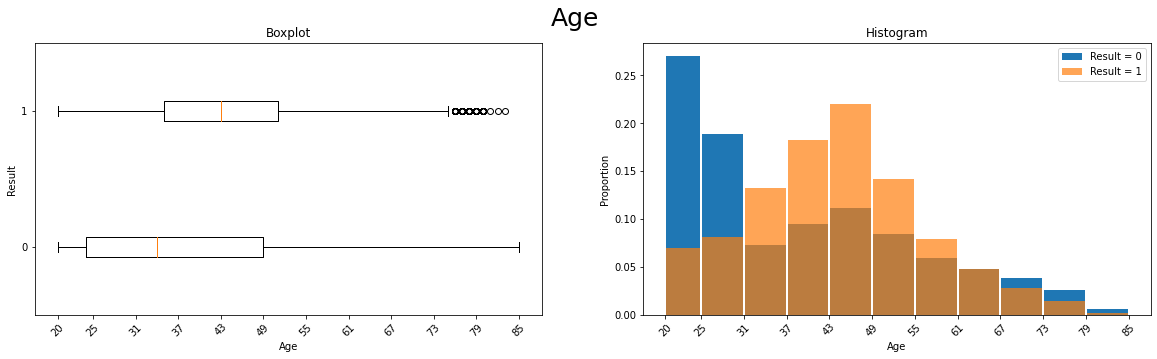

In [ ]:
draw_boxplot_hist("Age", 10)

There seems to be a distinct difference in the distribution of `Age` by the outcome of `Result`. On average, customers who purchase car insurance tend to be older, most often around 40-50, while those who don't are most often between 20-26 years old.

Before investigating `AnnualPremium`, I have to convert each string to a float by removing the £ sign and converting it:

In [ ]:
import re

eda["AnnualPremium"] = [float("".join(re.findall(r"[0-9\.]+", x))) for x in eda["AnnualPremium"]]

Summary:
 count    213420.00
mean       1527.70
std         858.99
min         131.50
25%        1219.84
50%        1582.55
75%        1969.60
max       27008.25
Name: AnnualPremium, dtype: float64

  Length of AnnualPremium with Result = 0: 187389
  Length of AnnualPremium with Result = 1: 26031
  


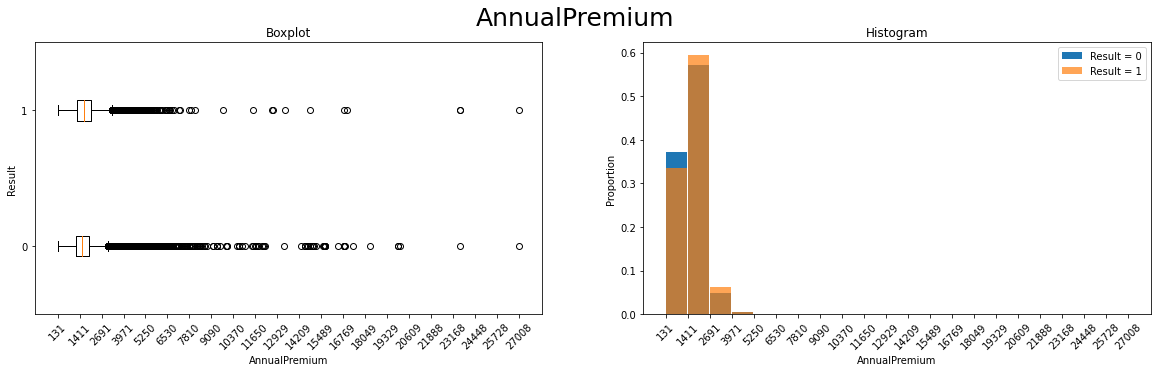

In [ ]:
draw_boxplot_hist("AnnualPremium", 20)

The vast majority of customers have annual premiums less than £2000 (75th percentile = £1969.60), but there are a lot of outliers reaching as high as around £27,000. 

From the bars that can be seen in the histogram, the distribution of `AnnualPremium` by `Result` is not significantly different. I can also check if this holds for higher values of `AnnualPremium` by plotting a histogram excluding premiums less than £5000:

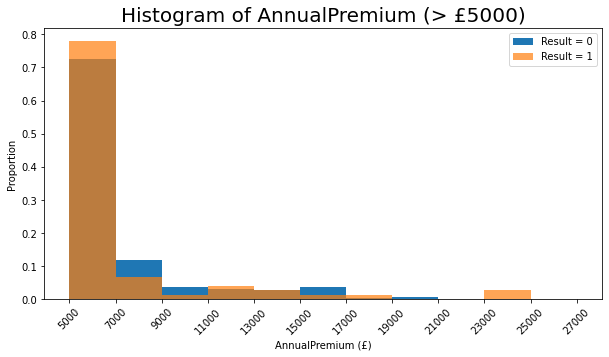

In [ ]:
x0 = eda.loc[(eda.Result == 0) & (eda.AnnualPremium > 5000), "AnnualPremium"]
x1 = eda.loc[(eda.Result == 1) & (eda.AnnualPremium > 5000), "AnnualPremium"]

plt.figure(figsize = (10,5))

plt.hist(x0, bins = range(5000, int(max(eda.AnnualPremium)), 2000), weights = np.ones(len(x0)) / len(x0))
plt.hist(x1, bins = range(5000, int(max(eda.AnnualPremium)), 2000), weights = np.ones(len(x1)) / len(x1), alpha = 0.7)
plt.xticks(range(5000, int(max(eda.AnnualPremium)), 2000), rotation = 45)
plt.title("Histogram of AnnualPremium (> £5000)", fontsize = 20)
plt.xlabel("AnnualPremium (£)")
plt.ylabel("Proportion")
plt.legend(["Result = 0", "Result = 1"])

plt.show()

Even for large annual premiums, there is no discernible difference in proportions by `Result`.

Summary:
 count    213420.00
mean        154.23
std          83.70
min          10.00
25%          82.00
50%         154.00
75%         227.00
max         299.00
Name: DaysSinceCreated, dtype: float64

  Length of DaysSinceCreated with Result = 0: 187389
  Length of DaysSinceCreated with Result = 1: 26031
  


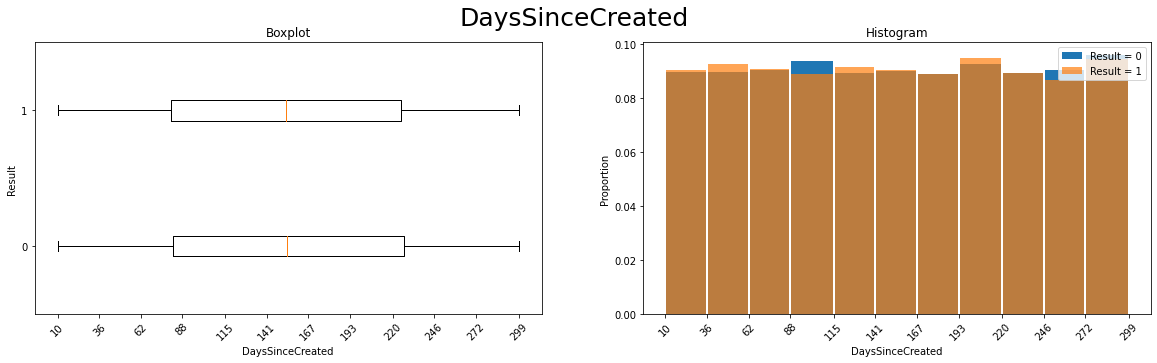

In [ ]:
draw_boxplot_hist("DaysSinceCreated", 10)

The minimum number of days since creation (of account) is 10, and the max is nearly a year at 299 days. The mean and median are both basically 155. I can see from the histogram that this feature is uniformly distributed, with no bin having especially more occurences than any other, also when split by result.

I can investigate the relationships between all the features by creating a correlation heatmap.

I convert the categorical features that are in string format to nominal categorical features first:

In [ ]:
eda_corr = eda.iloc[:,1:]

eda_corr.Gender = np.select([eda.Gender == "Male", eda.Gender == "Female"], [0, 1])
eda_corr.VehicleAge = np.select([eda.VehicleAge == "< 1 Year", eda.VehicleAge == "1-2 Year", eda.VehicleAge == "> 2 Years"], [0, 1, 2])
eda_corr.PastAccident = np.select([eda.PastAccident == "No", eda.PastAccident == "Yes"], [0, 1])

Text(0.5, 1.0, 'Correlation Heatmap')

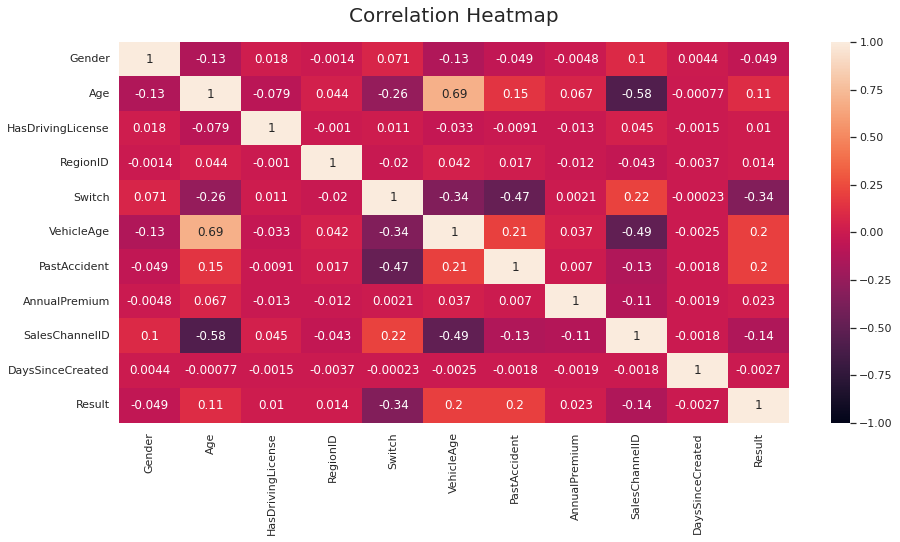

In [ ]:
import seaborn as sns

plt.figure(figsize = (15,7))
sns.set(font_scale = 1)
heatmap = sns.heatmap(eda_corr.corr(), vmin=-1, vmax=1, annot = True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad = 20)

The correlation coefficients here measure the linear relationship between two numeric variables where -1 is a perfect negative linear relationship, 1 is a perfect positive linear relationship, and 0 is no relationship.

One has to be careful when interpreting the coefficient in relation to nominal cateogircal variables that have more than 2 levels. For example a negative coefficient between `SalesChannelID` and `VehicleAge` (as is shown in the heatmap) means that the average vehicle age decreases as the numeric value of the sales channel ID increases. This doesn't make intuitive sense since the sales channel ID is not a variable number but a fixed category, but it does at least suggest that the average vehicle age is not uniform across all levels of `SalesChannelID`.

## Data Pre-Processing

#### Missing values

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213420 entries, 197336 to 143142
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 213420 non-null  int64  
 1   Gender             192153 non-null  object 
 2   Age                192068 non-null  float64
 3   HasDrivingLicense  192094 non-null  float64
 4   RegionID           192132 non-null  float64
 5   Switch             106880 non-null  float64
 6   VehicleAge         192247 non-null  object 
 7   PastAccident       106598 non-null  object 
 8   AnnualPremium      213420 non-null  object 
 9   SalesChannelID     213420 non-null  int64  
 10  DaysSinceCreated   213420 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 19.5+ MB


Many of the variables have missing values.

In [ ]:
print(X_train.isna().sum(), "\n")
print("Result", y_train.isna().sum())

id                        0
Gender                21267
Age                   21352
HasDrivingLicense     21326
RegionID              21288
Switch               106540
VehicleAge            21173
PastAccident         106822
AnnualPremium             0
SalesChannelID            0
DaysSinceCreated          0
dtype: int64 

Result 0


Thankfully, the response variables, `Result`, has no missing values.

`Gender` is dropped from the data because it is clear from the correlation matrix that it has minimal impact on `Result`.

For `Switch` and `PastAccident`, there are too many missing values for basic imputation to be applied without severely biasing the data, so they are dropped from the data.

`id` is also dropped because it is just a row identifier.

In [ ]:
X_train_clean = X_train.drop(["id", "Gender", "Switch", "PastAccident"], axis = 1)

For the remaining variables, I impute categorical variables with the mode value, and `Age` with the median value.

In [ ]:
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy = "most_frequent")
age_imputer = SimpleImputer(strategy = "median")

na_cat_features = ["HasDrivingLicense", "RegionID", "VehicleAge"]

X_train_clean[na_cat_features] = cat_imputer.fit_transform(X_train[na_cat_features])
X_train_clean[["Age"]] = age_imputer.fit_transform(X_train[["Age"]])

In [ ]:
X_train_clean.isna().sum()

Age                  0
HasDrivingLicense    0
RegionID             0
VehicleAge           0
AnnualPremium        0
SalesChannelID       0
DaysSinceCreated     0
dtype: int64

The data has no more missing values.

#### Feature transformation

The numeric features in the data will be scaled to [0,1], and the categorical features will be encoded with simple dummy variables if they have a few levels, or a binary encoder if they have many levels (`RegionID` and `SalesChannelID`).

Before scaling numeric features, I convert `AnnualPremium` from a string to a float:

In [ ]:
X_train_clean["AnnualPremium"] = [float("".join(re.findall(r"[0-9\.]+", x))) for x in X_train["AnnualPremium"]]

I use `MinMaxScaler` to scale the numeric features.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_features = ["Age", "AnnualPremium", "DaysSinceCreated"]

num_scaler = MinMaxScaler()

X_train_clean[num_features] = num_scaler.fit_transform(X_train_clean[num_features])

I then encode the categorical variables, for which I need the package `cateogory_encoders`.

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 8.0 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

cat_onehot_encoder = OneHotEncoder(drop = "first", sparse = False)
cat_binary_encoder = ce.BinaryEncoder(cols = ["RegionID", "SalesChannelID"], return_df = True)

cat_onehot_features_train = pd.DataFrame(cat_onehot_encoder.fit_transform(X_train_clean[["HasDrivingLicense", "VehicleAge"]]), columns = cat_onehot_encoder.get_feature_names_out())
cat_binary_features_train = cat_binary_encoder.fit_transform(X_train_clean[["RegionID", "SalesChannelID"]]).reset_index(drop = True)

cat_features = ["HasDrivingLicense", "VehicleAge", "RegionID", "SalesChannelID"]

X_train_clean = pd.concat([X_train_clean.drop(cat_features, axis = 1).reset_index(drop = True), cat_onehot_features_train, cat_binary_features_train], axis = 1)

In [ ]:
X_train_clean

,Age,AnnualPremium,DaysSinceCreated,HasDrivingLicense_1.0,VehicleAge_< 1 Year,VehicleAge_> 2 Years,RegionID_0,RegionID_1,RegionID_2,RegionID_3,RegionID_4,RegionID_5,SalesChannelID_0,SalesChannelID_1,SalesChannelID_2,SalesChannelID_3,SalesChannelID_4,SalesChannelID_5,SalesChannelID_6,SalesChannelID_7
0,0.061538,0.059821,0.224913,1.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0.076923,0.050155,0.352941,1.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0.000000,0.066012,0.961938,1.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0.538462,0.077039,0.173010,1.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0.292308,0.049420,0.813149,1.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213415,0.415385,0.119043,0.245675,1.0,0.0,0.0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
213416,0.846154,0.075580,0.003460,1.0,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0,1
213417,0.015385,0.070968,0.453287,1.0,1.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
213418,0.446154,0.071127,0.276817,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,1


#### Oversampling

Due to the class imbalance, I will use oversampling to create a balanced dataset with respect to `Result`. I will use a naive oversampling technique.

In [ ]:
Xy_train_clean = pd.concat([X_train_clean, y_train.reset_index(drop = True)], axis = 1)

n_over_train = sum(Xy_train_clean.Result == 0) - sum(Xy_train_clean.Result == 1)

Xy_train_over = Xy_train_clean.loc[Xy_train_clean.Result == 1, :].sample(n_over_train, replace = True)

Xy_train_clean_over = pd.concat([Xy_train_clean, Xy_train_over])

In [ ]:
print("Result before oversampling: \n", Xy_train_clean.Result.value_counts())
print("\n Result after oversampling: \n", Xy_train_clean_over.Result.value_counts())

Result before oversampling: 
 0    187389
1     26031
Name: Result, dtype: int64

 Result after oversampling: 
 0    187389
1    187389
Name: Result, dtype: int64


I also split the data again into X and y for modelling:

In [ ]:
X_train_clean_over = Xy_train_clean_over.drop("Result", axis = 1)
y_train_clean_over = Xy_train_clean_over.Result

Before moving on to modelling, I have to transform the test data according to the data pre-processing methods I have just used on the training data.

The process can be summarised in to these steps:

- Drop `id`, `Gender`, `Switch`, and `PastAccident`.
- Impute `HasDrivingLicense`, `RegionID`, and `VehicleAge` with the mode for each feature.
- Impute `Age` using the median age.
- Convert `AnnualPremium` to a float.
- Scale `Age`, `AnnualPremium`, and `DaysSinceCreated` to [0,1].
- Encode `HasDrivingLicense` and `VehicleAge` using OneHotEncoder.
- Encode `RegionID` and `SalesChannelID` using binary encoder.
- Naive oversampling of data to balance `Result`.

In [ ]:
X_test_clean = X_test.drop(["id", "Gender", "Switch", "PastAccident"], axis = 1)

X_test_clean[["HasDrivingLicense", "RegionID", "VehicleAge"]] = cat_imputer.transform(X_test_clean[["HasDrivingLicense", "RegionID", "VehicleAge"]])
X_test_clean[["Age"]] = age_imputer.transform(X_test_clean[["Age"]])

X_test_clean.AnnualPremium = [float("".join(re.findall(r"[0-9\.]+", x))) for x in X_test_clean["AnnualPremium"]]

X_test_clean[["Age", "AnnualPremium", "DaysSinceCreated"]] = num_scaler.transform(X_test_clean[["Age", "AnnualPremium", "DaysSinceCreated"]])

cat_onehot_features_test = pd.DataFrame(cat_onehot_encoder.fit_transform(X_test_clean[["HasDrivingLicense", "VehicleAge"]]), columns = cat_onehot_encoder.get_feature_names_out())
cat_binary_features_test = cat_binary_encoder.fit_transform(X_test_clean[["RegionID", "SalesChannelID"]]).reset_index(drop = True)

X_test_clean = pd.concat([X_test_clean.drop(cat_features, axis = 1).reset_index(drop = True), cat_onehot_features_test, cat_binary_features_test], axis = 1)

In [ ]:
Xy_test_clean = pd.concat([X_test_clean, y_test.reset_index(drop = True)], axis = 1)

n_over_test = sum(Xy_test_clean.Result == 0) - sum(Xy_test_clean.Result == 1)

Xy_test_over = Xy_test_clean.loc[Xy_test_clean.Result == 1, :].sample(n_over_test, replace = True)

Xy_test_clean_over = pd.concat([Xy_test_clean, Xy_test_over])

X_test_clean_over = Xy_test_clean_over.drop("Result", axis = 1)
y_test_clean_over = Xy_test_clean_over.Result

In [ ]:
y_test_clean_over.value_counts()

0    80311
1    80311
Name: Result, dtype: int64

## Modelling

#### Stratified sampling for optimisation

In [ ]:
n = 10000

Xy_train_sub = Xy_train_clean_over.groupby("Result", group_keys = False).apply(lambda x: x.sample(frac = n / len(Xy_train_clean_over), random_state = 1))
X_train_sub = Xy_train_sub.drop("Result", axis = 1)
y_train_sub = Xy_train_sub.Result

Xy_test_sub = Xy_test_clean_over.groupby("Result", group_keys = False).apply(lambda x: x.sample(frac = n / len(Xy_test_clean_over), random_state = 1))
X_test_sub = Xy_test_sub.drop("Result", axis = 1)
y_test_sub = Xy_test_sub.Result

### k-NN

k-nearest neighbour algorithms look at the value of the output for nearby points around a point of interest and assign the most common value to the point of interest.

The main hyperparameter here is the number of neighbours considered when classifying.

I optimise the k-NN model by fitting it for different values of `n_neighbors`.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

range_n = [1,5,10,25,50,100,500,1000]

precisions = {}
recalls = {}
Fs = {}

for n in range_n:
  knn_n = KNeighborsClassifier(n_neighbors = n)
  knn_n.fit(X_train_sub, y_train_sub)
  y_pred_n = knn_n.predict(X_test_sub)

  p = metrics.precision_score(y_test_sub, y_pred_n)
  precisions[n] = p

  r = metrics.recall_score(y_test_sub, y_pred_n)
  recalls[n] = r

  F = metrics.f1_score(y_test_sub, y_pred_n)
  Fs[n] = F

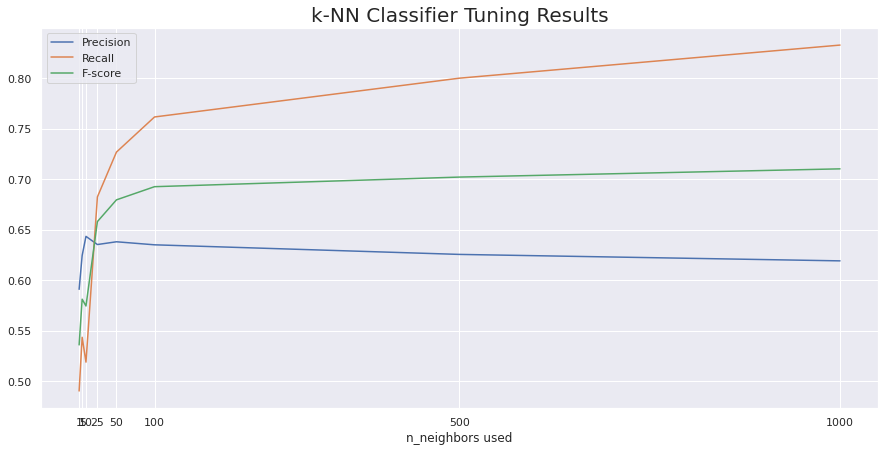

In [ ]:
plt.figure(figsize = (15,7))

plt.plot(list(precisions.keys()), list(precisions.values()))
plt.plot(list(recalls.keys()), list(recalls.values()))
plt.plot(list(Fs.keys()), list(Fs.values()))
plt.xlabel("n_neighbors used")
plt.xticks(range_n)
plt.title("k-NN Classifier Tuning Results", fontsize = 20)
plt.legend(["Precision", "Recall", "F-score"])

plt.show()

It appears like the recall keeps increasing, I explore this by looking at larger values for n_neighbors.

In [ ]:
range_n = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]

precisions = {}
recalls = {}
Fs = {}

for n in range_n:
  knn_n = KNeighborsClassifier(n_neighbors = n)
  knn_n.fit(X_train_sub, y_train_sub)
  y_pred_n = knn_n.predict(X_test_sub)

  p = metrics.precision_score(y_test_sub, y_pred_n)
  precisions[n] = p

  r = metrics.recall_score(y_test_sub, y_pred_n)
  recalls[n] = r

  F = metrics.f1_score(y_test_sub, y_pred_n)
  Fs[n] = F

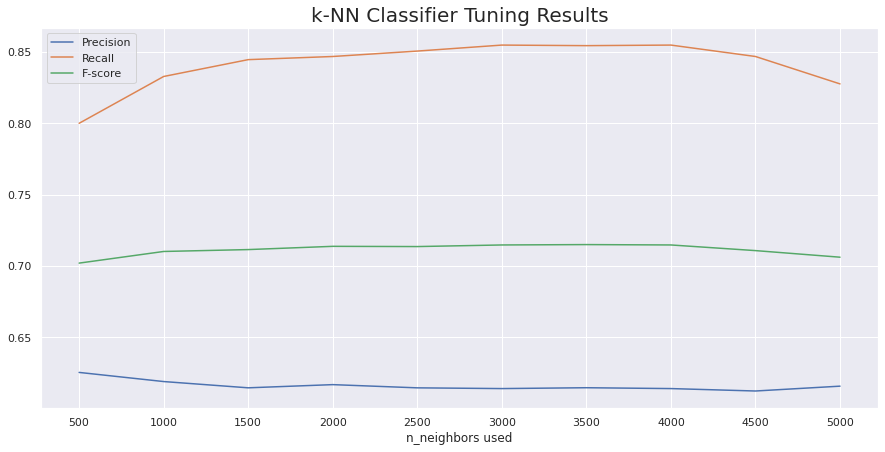

In [ ]:
plt.figure(figsize = (15,7))

plt.plot(list(precisions.keys()), list(precisions.values()))
plt.plot(list(recalls.keys()), list(recalls.values()))
plt.plot(list(Fs.keys()), list(Fs.values()))
plt.xlabel("n_neighbors used")
plt.xticks(range_n)
plt.title("k-NN Classifier Tuning Results", fontsize = 20)
plt.legend(["Precision", "Recall", "F-score"])

plt.show()

There is little improvement after n = 1500, before dropping off after n = 3500. Therefore, I use n = 1500 for our optimal model and use it to predict the overall test data.

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors = 1500)
knn_classifier.fit(X_train_clean_over, y_train_clean_over)

y_pred_knn = knn_classifier.predict(X_test_clean_over)

### Logistic regression

Logisitc regression is a linear model which assigns to each point a probability of it being positive (and a probability for it being negative).

Then, the probability cutoff point must be decided (0.5 by default) to choose when to assign to each class.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state = 1)
lr_classifier.fit(X_train_sub, y_train_sub)

y_probs_lr = lr_classifier.predict_proba(X_test_sub)

Optimise the probability threshold for classifying:

In [ ]:
thresholds = [x / 100 for x in list(range(0,105,5))]

precisions = []
recalls = []
Fs = []

for t in thresholds:
  y_pred_t =  list(y_probs_lr[:,1] > t)

  p = metrics.precision_score(y_test_sub, y_pred_t, zero_division = 1)
  precisions = np.append(precisions, p)

  r = metrics.recall_score(y_test_sub, y_pred_t)
  recalls = np.append(recalls, r)

  F = metrics.f1_score(y_test_sub, y_pred_t)
  Fs = np.append(Fs, F)

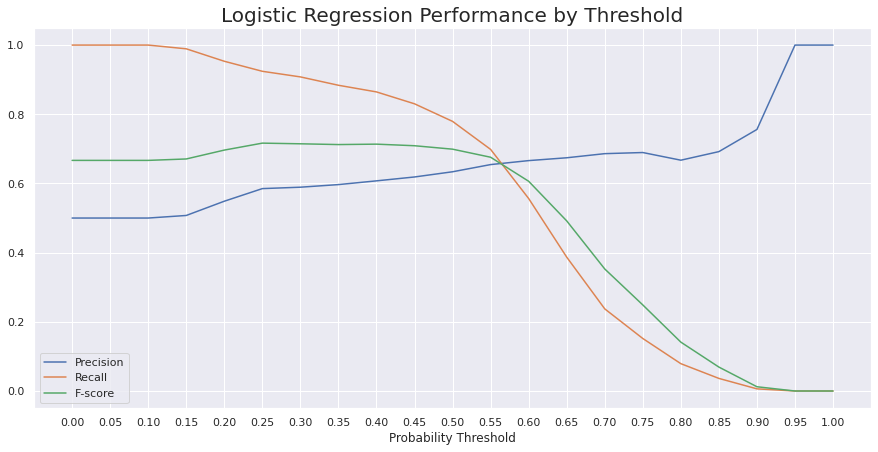

In [ ]:
plt.figure(figsize = (15,7))

plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, Fs)
plt.xticks(thresholds)
plt.xlabel("Probability Threshold")
plt.title("Logistic Regression Performance by Threshold", fontsize = 20)
plt.legend(["Precision", "Recall", "F-score"])

plt.show()

I choose `threshold = 0.25` to maximise F-score.

In [ ]:
lr_classifier.fit(X_train_clean_over, y_train_clean_over)

y_probs_lr = lr_classifier.predict_proba(X_test_clean_over)

y_pred_lr = np.asarray(y_probs_lr[:,1] > 0.25, dtype = "int")

### Decision tree

Decision trees are non-linear models that apply sequential if-else conditions to classify points based on individual features in turn.

There are a number of hyperparameters which can be optimised here including the Goodness function (criterion), the depth of the tree, etc.

I optimise these as well as the minimum samples required to create a new node, and the maximum number of leaf nodes.

The hyperparameters of the decision tree will be optimised using random search.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import randint

space = dict(criterion = ['gini', 'entropy'],
         max_depth = randint(1, 100), 
         min_samples_split = randint(100,10000), 
         max_leaf_nodes = randint(2, 100))

tree_classifier = DecisionTreeClassifier(random_state = 1)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = RandomizedSearchCV(tree_classifier, space, n_iter = 1000, scoring = "f1", cv = cv, random_state = 1)

best_model = search.fit(X_train_sub, y_train_sub)

In [ ]:
best_model.best_score_

0.7393900533504734

In [ ]:
best_model.best_params_

{'criterion': 'entropy',
 'max_depth': 18,
 'max_leaf_nodes': 44,
 'min_samples_split': 120}

I use the model found above as our classifier on the full data.

In [ ]:
tree_classifier = DecisionTreeClassifier(criterion = "gini", max_depth = 13, max_leaf_nodes = 19, min_samples_split = 171)

tree_classifier.fit(X_train_clean_over, y_train_clean_over)

y_pred_tree = tree_classifier.predict(X_test_clean_over)

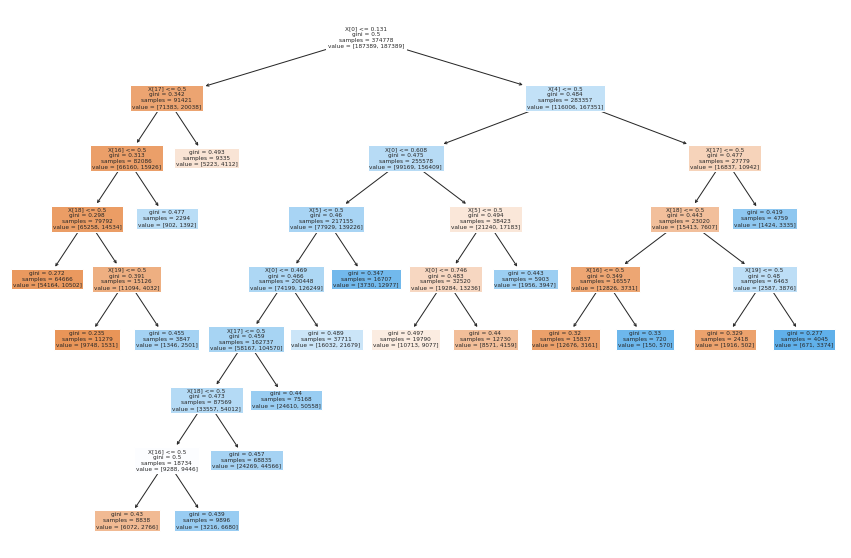

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,10))

plot_tree(tree_classifier, filled = True)

plt.show()

## Model Evaluation

I compare precision, recall, and F-scores of each model.

K-NN:

In [ ]:
print(metrics.classification_report(y_test_clean_over, y_pred_knn))

print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test_clean_over, y_pred_knn))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62     80311
           1       0.63      0.76      0.69     80311

    accuracy                           0.66    160622
   macro avg       0.67      0.66      0.66    160622
weighted avg       0.67      0.66      0.66    160622


Confusion matrix:
 [[45129 35182]
 [19534 60777]]


Linear regression:

In [ ]:
print(metrics.classification_report(y_test_clean_over, y_pred_lr))

print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test_clean_over, y_pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.34      0.48     80311
           1       0.58      0.92      0.71     80311

    accuracy                           0.63    160622
   macro avg       0.70      0.63      0.60    160622
weighted avg       0.70      0.63      0.60    160622


Confusion matrix:
 [[27023 53288]
 [ 6078 74233]]


Decision tree:

In [ ]:
print(metrics.classification_report(y_test_clean_over, y_pred_tree))

print("\nConfusion matrix:\n", metrics.confusion_matrix(y_test_clean_over, y_pred_tree))

              precision    recall  f1-score   support

           0       0.71      0.53      0.61     80311
           1       0.63      0.79      0.70     80311

    accuracy                           0.66    160622
   macro avg       0.67      0.66      0.65    160622
weighted avg       0.67      0.66      0.65    160622


Confusion matrix:
 [[42504 37807]
 [17255 63056]]


Also compare the ROC curves and AUC scores.

<Figure size 1440x1440 with 0 Axes>

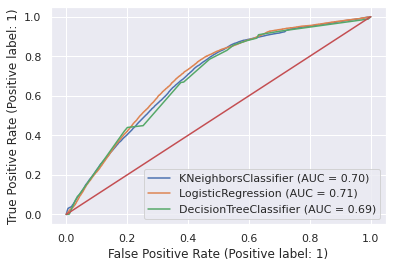

In [ ]:
plt.figure(figsize = (20,20))

fig = metrics.RocCurveDisplay.from_estimator(knn_classifier, X_test_clean_over, y_test_clean_over)
metrics.RocCurveDisplay.from_estimator(lr_classifier, X_test_clean_over, y_test_clean_over, ax = fig.ax_)
metrics.RocCurveDisplay.from_estimator(tree_classifier, X_test_clean_over, y_test_clean_over, ax = fig.ax_)
plt.plot([0,1])

plt.show()